In [9]:
import sys, subprocess
print("EXE:", sys.executable)
print("F2PY:", subprocess.getoutput("which f2py"))
print("NP‑CONFIG:", subprocess.getoutput("which numpy-config"))


EXE: /share/apps/anaconda3/2024.02/bin/python
F2PY: /share/apps/anaconda3/2024.02/bin/f2py
NP‑CONFIG: which: no numpy-config in (/share/apps/anaconda3/2024.02/bin:/share/apps/singularity/bin:/share/apps/local/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/usr/lpp/mmfs/bin:/opt/slurm/bin)


In [6]:
!pip install pymc
!pip install setuptools numpy 

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
streamlit 1.30.0 requires rich<14,>=10.14.0, but you have rich 14.0.0 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip uninstall backports
!pip install --upgrade setuptools jaraco.context

Defaulting to user installation because normal site-packages is not writeable


 # Bayesian Inference with Hierarchical Priors
 
 - Each gene has its own log expression "offset" drawn from (mu_gene, sigma_gene).
 - Each condition has its own log intercept "offset" drawn from (mu_cond, sigma_cond).
 - This treats genes and conditions as categories in a hierarchical model.
 - We compare the posterior means of these offsets to the *true* values.

In [1]:
import os

# These MUST come before importing pymc or pytensor
os.environ["PYTENSOR_FLAGS"] = "optimizer_excluding=constant_folding,mode=FAST_RUN,linker=py"
os.environ["PYTENSOR_WARN__C_COMPILE"] = "False"

import pytensor
pytensor.config.cxx = ""

# Now import pymc
import pymc as pm
import arviz as az

import pytensor
print("Linker:", pytensor.config.linker)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Linker: py


In [2]:
import logging

# Set logging to display INFO level messages
logger = logging.getLogger("pymc")
logger.setLevel(logging.INFO)

import sys
handler = logging.StreamHandler(sys.stdout)  # Redirect to notebook output
logger.addHandler(handler)


Simulated Data (first 10 rows):
     Gene    Condition  True_Expression  Condition_Intercept  Gene_Length  \
0  Gene_1  Condition_1         6.572745             1.281918  2215.089704   
1  Gene_1  Condition_2         6.572745             0.933203  2215.089704   
2  Gene_1  Condition_3         6.572745             1.382432  2215.089704   
3  Gene_1  Condition_4         6.572745             2.141518  2215.089704   
4  Gene_1  Condition_5         6.572745             0.889517  2215.089704   
5  Gene_2  Condition_1        16.274613             1.281918  1341.048247   
6  Gene_2  Condition_2        16.274613             0.933203  1341.048247   
7  Gene_2  Condition_3        16.274613             1.382432  1341.048247   
8  Gene_2  Condition_4        16.274613             2.141518  1341.048247   
9  Gene_2  Condition_5        16.274613             0.889517  1341.048247   

   Observed_Counts  
0                5  
1                0  
2                0  
3                1  
4              

/state/partition1/job-59834278/ipykernel_2925692/1512794026.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_condition, labels=conditions)


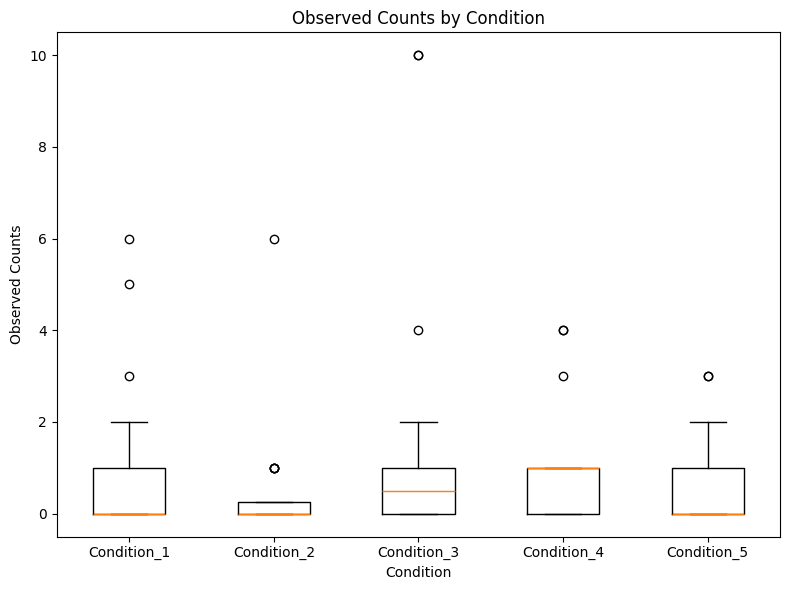

In [3]:
# %% [markdown]
# # Simulation: Negative Binomial Counts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# --------------------------
# Simulation Parameters
# --------------------------
n_genes = 20
n_conditions = 5

# Simulate condition intercepts on log-scale
condition_log_intercepts = np.random.normal(loc=0.0, scale=0.5, size=n_conditions)
condition_intercepts = np.exp(condition_log_intercepts)

# Simulate true gene expression on log-scale
true_log_expression = np.random.normal(loc=2.0, scale=0.5, size=n_genes)
true_expression = np.exp(true_log_expression)

# Sequencing Depth and Gene Length
seq_depth = 1e4
gene_lengths = np.random.uniform(low=1000, high=3000, size=n_genes)

# Overdispersion (phi = 1 means moderate overdispersion)
phi = 1.0

# Reference values for scaling
ref_seq_depth = 1e5
ref_gene_length = 2000.0

# --------------------------
# Simulate Observed Read Counts
# --------------------------
observed_counts = np.zeros((n_genes, n_conditions), dtype=int)
for g in range(n_genes):
    for c in range(n_conditions):
        base_mean = true_expression[g] * condition_intercepts[c]
        scaled_mean = base_mean * (seq_depth / ref_seq_depth) * (gene_lengths[g] / ref_gene_length)
        r = 1.0 / phi
        p = r / (r + scaled_mean)
        observed_counts[g, c] = np.random.negative_binomial(r, p)

# Prepare a long-format DataFrame for inspection
data_records = []
for g in range(n_genes):
    for c in range(n_conditions):
        data_records.append({
            'Gene': f'Gene_{g+1}',
            'Condition': f'Condition_{c+1}',
            'True_Expression': true_expression[g],
            'Condition_Intercept': condition_intercepts[c],
            'Gene_Length': gene_lengths[g],
            'Observed_Counts': observed_counts[g, c]
        })
df_simulated = pd.DataFrame(data_records)

print("Simulated Data (first 10 rows):")
print(df_simulated.head(10))

# Quick boxplot
plt.figure(figsize=(8,6))
conditions = df_simulated['Condition'].unique()
data_by_condition = [df_simulated[df_simulated['Condition'] == cond]['Observed_Counts'] 
                     for cond in conditions]
plt.boxplot(data_by_condition, labels=conditions)
plt.title("Observed Counts by Condition")
plt.xlabel("Condition")
plt.ylabel("Observed Counts")
plt.tight_layout()
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gene, sigma_gene, gene_log_expression, mu_cond, sigma_cond, condition_intercepts_log, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 981 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


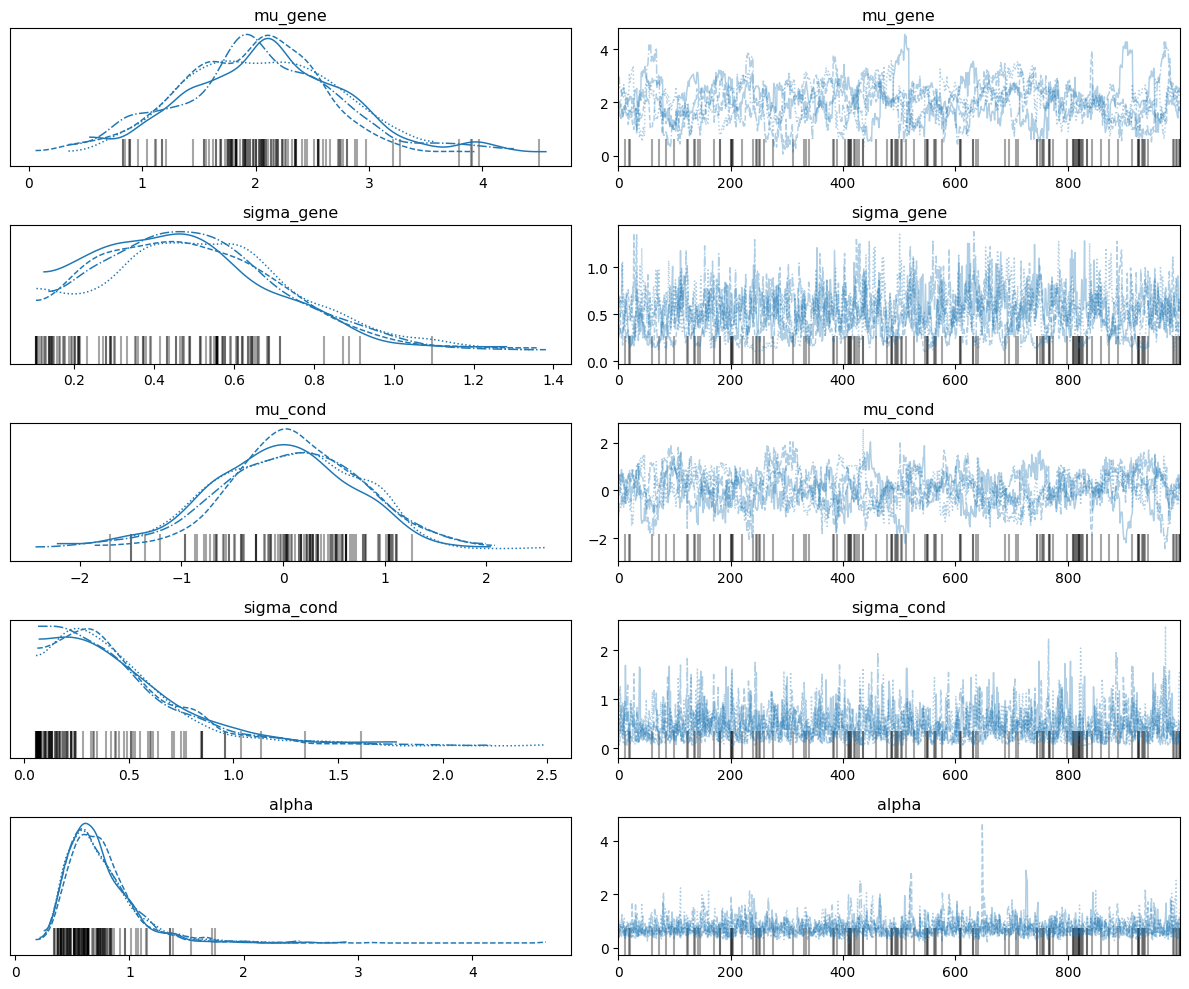

True Gene Log Expression vs Posterior Means:
Gene_1: true=1.88, post_mean=2.15
Gene_2: true=2.79, post_mean=2.23
Gene_3: true=2.38, post_mean=2.09
Gene_4: true=1.77, post_mean=1.86
Gene_5: true=2.27, post_mean=2.29
Gene_6: true=1.77, post_mean=2.04
Gene_7: true=1.77, post_mean=1.90
Gene_8: true=2.12, post_mean=1.97
Gene_9: true=1.04, post_mean=1.60
Gene_10: true=1.14, post_mean=1.86
Gene_11: true=1.72, post_mean=2.16
Gene_12: true=1.49, post_mean=1.74
Gene_13: true=2.16, post_mean=2.15
Gene_14: true=1.55, post_mean=2.03
Gene_15: true=1.29, post_mean=1.99
Gene_16: true=2.73, post_mean=2.80
Gene_17: true=1.89, post_mean=1.78
Gene_18: true=2.03, post_mean=2.28
Gene_19: true=1.29, post_mean=2.00
Gene_20: true=1.73, post_mean=1.82

True Condition Log Intercepts vs Posterior Means:
Condition_1: true=0.25, post_mean=0.03
Condition_2: true=-0.07, post_mean=-0.22
Condition_3: true=0.32, post_mean=0.34
Condition_4: true=0.76, post_mean=0.26
Condition_5: true=-0.12, post_mean=-0.05


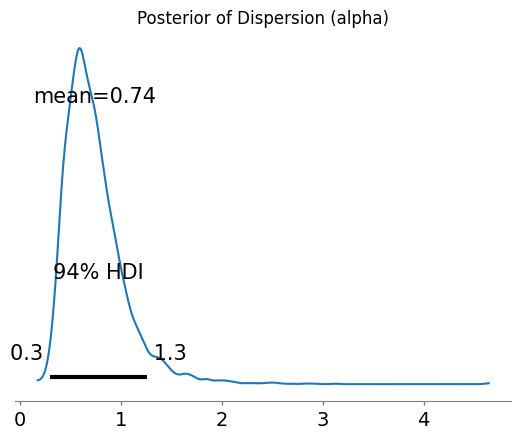

In [3]:



with pm.Model() as model:
    # --------------------------
    # Gene-level random intercepts
    # --------------------------
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)        # global average for genes
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)      # how much genes vary around mu_gene
    gene_log_expression = pm.Normal(
        "gene_log_expression",
        mu=mu_gene,
        sigma=sigma_gene,
        shape=n_genes
    )

    # --------------------------
    # Condition-level random intercepts
    # --------------------------
    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)        # global average for conditions
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)      # how much conditions vary around mu_cond
    condition_intercepts_log = pm.Normal(
        "condition_intercepts_log",
        mu=mu_cond,
        sigma=sigma_cond,
        shape=n_conditions
    )

    # --------------------------
    # Dispersion (alpha > 0)
    # --------------------------
    alpha = pm.HalfCauchy('alpha', beta=2)

    # --------------------------
    # Compute the mean expression
    # --------------------------
    # log_mu[g, c] = gene_log_expression[g] + condition_intercepts_log[c]
    #              + log(seq_depth/ref_seq_depth) + log(gene_length[g]/ref_gene_length)
    log_mu = gene_log_expression[:, None] + condition_intercepts_log[None, :]
    log_mu += np.log(seq_depth / ref_seq_depth)
    log_mu += np.log(gene_lengths[:, None] / ref_gene_length)

    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # --------------------------
    # Likelihood: Negative Binomial
    # --------------------------
    observed = pm.NegativeBinomial(
        'observed',
        mu=mu,
        alpha=alpha,
        observed=observed_counts
    )

    # Sample from the posterior
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True
    )

# %%
# Posterior Analysis: Compare to True Values

# Plot or print summary of the main parameters
az.plot_trace(trace, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

# Compare posterior means to the true gene/condition values used in simulation
post_gene_log_expr = trace.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

print("True Gene Log Expression vs Posterior Means:")
for i in range(n_genes):
    print(f"Gene_{i+1}: true={true_log_expression[i]:.2f}, post_mean={post_gene_log_expr[i]:.2f}")

print("\nTrue Condition Log Intercepts vs Posterior Means:")
for j in range(n_conditions):
    print(f"Condition_{j+1}: true={condition_log_intercepts[j]:.2f}, post_mean={post_cond_log_int[j]:.2f}")

# Posterior for alpha
az.plot_posterior(trace, var_names=['alpha'])
plt.title("Posterior of Dispersion (alpha)")
plt.show()


In [4]:
az.summary(trace)
           

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_gene                 2.023  0.726   0.621    3.276      0.100    0.071   
gene_log_expression[0]  2.133  0.826   0.511    3.602      0.079    0.056   
gene_log_expression[1]  2.210  0.830   0.575    3.715      0.102    0.072   
gene_log_expression[2]  2.070  0.823   0.516    3.615      0.104    0.074   
gene_log_expression[3]  1.844  0.845   0.318    3.470      0.117    0.083   
...                       ...    ...     ...      ...        ...      ...   
mu[19, 0]               0.520  0.313   0.068    1.006      0.008    0.006   
mu[19, 1]               0.412  0.248   0.047    0.850      0.008    0.006   
mu[19, 2]               0.709  0.449   0.112    1.407      0.013    0.009   
mu[19, 3]               0.645  0.367   0.111    1.270      0.013    0.009   
mu[19, 4]               0.466  0.262   0.053    0.905      0.005    0.003   

                        ess_bulk  ess_tail  r_hat  
mu_gene                     54.0     223.0   1.07  
gene_log_expression[0]     109.0     484.0   1.05  
gene_log_expression[1]      65.0     336.0   1.05  
gene_log_expression[2]      62.0     308.0   1.06  
gene_log_expression[3]      53.0     307.0   1.06  
...                          ...       ...    ...  
mu[19, 0]                 1057.0    2308.0   1.01  
mu[19, 1]                  433.0    1616.0   1.01  
mu[19, 2]                 1047.0    1663.0   1.01  
mu[19, 3]                  712.0    1514.0   1.01  
mu[19, 4]                 2207.0    1989.0   1.00  

[130 rows x 9 columns]

In [5]:
import arviz as az

# Define a list of the hierarchical parameters (exclude gene_log_expression and mu)
hierarchical_vars = ["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"]

# Generate the summary for these parameters only
hierarchical_summary = az.summary(trace, var_names=hierarchical_vars)
print(hierarchical_summary)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_gene     2.023  0.726   0.621    3.276      0.100    0.071      54.0   
sigma_gene  0.497  0.224   0.077    0.877      0.025    0.018      54.0   
mu_cond     0.085  0.717  -1.286    1.414      0.085    0.060      72.0   
sigma_cond  0.456  0.289   0.059    0.963      0.010    0.007     682.0   
alpha       0.734  0.288   0.296    1.281      0.009    0.006    1371.0   

            ess_tail  r_hat  
mu_gene        223.0   1.07  
sigma_gene      34.0   1.06  
mu_cond        304.0   1.06  
sigma_cond     725.0   1.01  
alpha         1804.0   1.01  


# Bayesian Inference with Hierarchical Non-Centered Parameterization

Using non-centered parameterization for both the gene-level and condition-level intercepts.
Instead of sampling gene_log_expression directly as Normal(mu_gene, sigma_gene),
we sample z_gene ~ Normal(0, 1) and then set:
    gene_log_expression = mu_gene + sigma_gene * z_gene

We do the same for condition intercepts.


In [6]:

import pymc as pm
import numpy as np
import arviz as az

with pm.Model() as model:
    # --------------------------
    # Gene-level non-centered parameterization
    # --------------------------
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)       # Global average for gene log-expression
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)       # Variability among genes
    z_gene = pm.Normal("z_gene", mu=0, sigma=1, shape=n_genes)  # Auxiliary standard normal for genes
    gene_log_expression = pm.Deterministic("gene_log_expression", mu_gene + sigma_gene * z_gene)
    
    # --------------------------
    # Condition-level non-centered parameterization
    # --------------------------
    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)        # Global average for condition log-intercepts
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)        # Variability among conditions
    z_cond = pm.Normal("z_cond", mu=0, sigma=1, shape=n_conditions)  # Auxiliary standard normal for conditions
    condition_intercepts_log = pm.Deterministic("condition_intercepts_log", mu_cond + sigma_cond * z_cond)
    
    # --------------------------
    # Dispersion (alpha > 0)
    # --------------------------
    alpha = pm.HalfCauchy('alpha', beta=2)
    
    # --------------------------
    # Compute the mean expression
    # --------------------------
    # log_mu[g, c] = gene_log_expression[g] + condition_intercepts_log[c]
    #              + log(seq_depth/ref_seq_depth) + log(gene_length[g]/ref_gene_length)
    log_mu = gene_log_expression[:, None] + condition_intercepts_log[None, :]
    log_mu += np.log(seq_depth / ref_seq_depth)
    log_mu += np.log(gene_lengths[:, None] / ref_gene_length)
    
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))
    
    # --------------------------
    # Likelihood: Negative Binomial
    # --------------------------
    observed = pm.NegativeBinomial('observed', mu=mu, alpha=alpha, observed=observed_counts)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gene, sigma_gene, z_gene, mu_cond, sigma_cond, z_cond, alpha]


/scratch/hr2547/myenv/lib64/python3.9/site-packages/pytensor/scalar/basic.py:3100: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/scratch/hr2547/myenv/lib64/python3.9/site-packages/pytensor/scalar/basic.py:2932: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/scratch/hr2547/myenv/lib64/python3.9/site-packages/pytensor/scalar/basic.py:2006: RuntimeWarning: invalid value encountered in divide
  return x / y
/scratch/hr2547/myenv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x152ac7515a60>
Traceback (most recent call last):
  File "/usr/lib64/python3.9/tempfile.py", line 460, in __del__
    def __del__(self):
KeyboardInterrupt: 


ValueError: Not enough samples to build a trace.

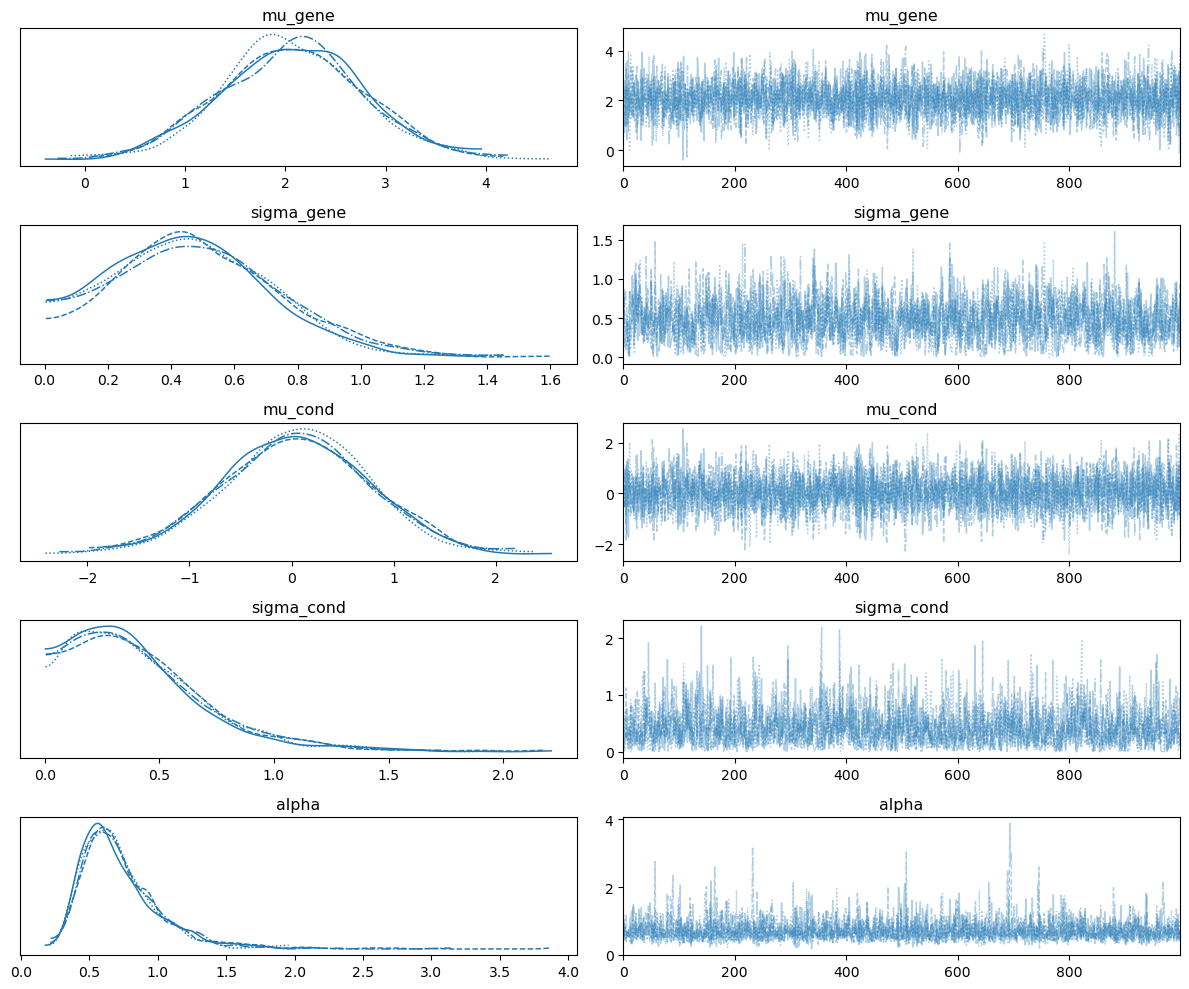

True Gene Log Expression vs Posterior Means:
Gene_1: true=1.88, post_mean=2.18
Gene_2: true=2.79, post_mean=2.25
Gene_3: true=2.38, post_mean=2.12
Gene_4: true=1.77, post_mean=1.90
Gene_5: true=2.27, post_mean=2.29
Gene_6: true=1.77, post_mean=2.07
Gene_7: true=1.77, post_mean=1.94
Gene_8: true=2.12, post_mean=2.02
Gene_9: true=1.04, post_mean=1.66
Gene_10: true=1.14, post_mean=1.90
Gene_11: true=1.72, post_mean=2.19
Gene_12: true=1.49, post_mean=1.79
Gene_13: true=2.16, post_mean=2.16
Gene_14: true=1.55, post_mean=2.06
Gene_15: true=1.29, post_mean=2.03
Gene_16: true=2.73, post_mean=2.78
Gene_17: true=1.89, post_mean=1.84
Gene_18: true=2.03, post_mean=2.30
Gene_19: true=1.29, post_mean=2.03
Gene_20: true=1.73, post_mean=1.86

True Condition Log Intercepts vs Posterior Means:
Condition_1: true=0.25, post_mean=0.01
Condition_2: true=-0.07, post_mean=-0.22
Condition_3: true=0.32, post_mean=0.31
Condition_4: true=0.76, post_mean=0.22
Condition_5: true=-0.12, post_mean=-0.07


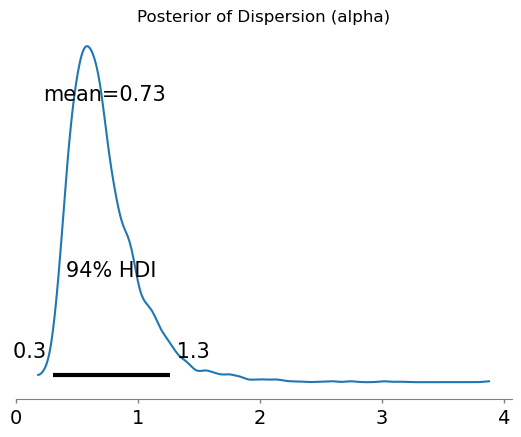

In [8]:
# %%
# Posterior Analysis: Compare to True Values

# Plot or print summary of the main parameters
az.plot_trace(trace, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

# Compare posterior means to the true gene/condition values used in simulation
post_gene_log_expr = trace.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

print("True Gene Log Expression vs Posterior Means:")
for i in range(n_genes):
    print(f"Gene_{i+1}: true={true_log_expression[i]:.2f}, post_mean={post_gene_log_expr[i]:.2f}")

print("\nTrue Condition Log Intercepts vs Posterior Means:")
for j in range(n_conditions):
    print(f"Condition_{j+1}: true={condition_log_intercepts[j]:.2f}, post_mean={post_cond_log_int[j]:.2f}")

# Posterior for alpha
az.plot_posterior(trace, var_names=['alpha'])
plt.title("Posterior of Dispersion (alpha)")
plt.show()


In [9]:
import arviz as az

# Define a list of the hierarchical parameters (exclude gene_log_expression and mu)
hierarchical_vars = ["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"]

# Generate the summary for these parameters only
hierarchical_summary = az.summary(trace, var_names=hierarchical_vars)
print(hierarchical_summary)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_gene     2.068  0.710   0.699    3.358      0.011    0.012    4233.0   
sigma_gene  0.473  0.254   0.008    0.897      0.006    0.003    1547.0   
mu_cond     0.054  0.712  -1.251    1.418      0.011    0.012    4117.0   
sigma_cond  0.413  0.303   0.000    0.950      0.007    0.006    1469.0   
alpha       0.727  0.306   0.302    1.263      0.006    0.013    3074.0   

            ess_tail  r_hat  
mu_gene       2882.0    1.0  
sigma_gene    1886.0    1.0  
mu_cond       2753.0    1.0  
sigma_cond    1782.0    1.0  
alpha         2464.0    1.0  


In [10]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_gene    2.068  0.710   0.699    3.358      0.011    0.012    4233.0   
z_gene[0]  0.188  0.852  -1.345    1.816      0.011    0.014    6331.0   
z_gene[1]  0.323  0.862  -1.348    1.896      0.011    0.015    6449.0   
z_gene[2]  0.081  0.878  -1.550    1.748      0.011    0.016    6293.0   
z_gene[3] -0.315  0.892  -2.055    1.253      0.012    0.017    5621.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu[19, 0]  0.518  0.288   0.085    0.993      0.005    0.008    3899.0   
mu[19, 1]  0.423  0.246   0.059    0.846      0.004    0.006    3172.0   
mu[19, 2]  0.689  0.375   0.130    1.378      0.006    0.008    3600.0   
mu[19, 3]  0.637  0.357   0.116    1.273      0.006    0.009    4256.0   
mu[19, 4]  0.478  0.264   0.086    0.935      0.004    0.006    3737.0   

           ess_tail  r_hat  
mu_gene      2882.0    1.0  
z_gene[0]    3157.0    1.0  
z_gene[1]    2965.0    1.0  
z_gene[2]    2711.0    1.0  
z_gene[3]    2734.0    1.0  
...             ...    ...  
mu[19, 0]    3002.0    1.0  
mu[19, 1]    3544.0    1.0  
mu[19, 2]    3213.0    1.0  
mu[19, 3]    3463.0    1.0  
mu[19, 4]    3231.0    1.0  

[155 rows x 9 columns]

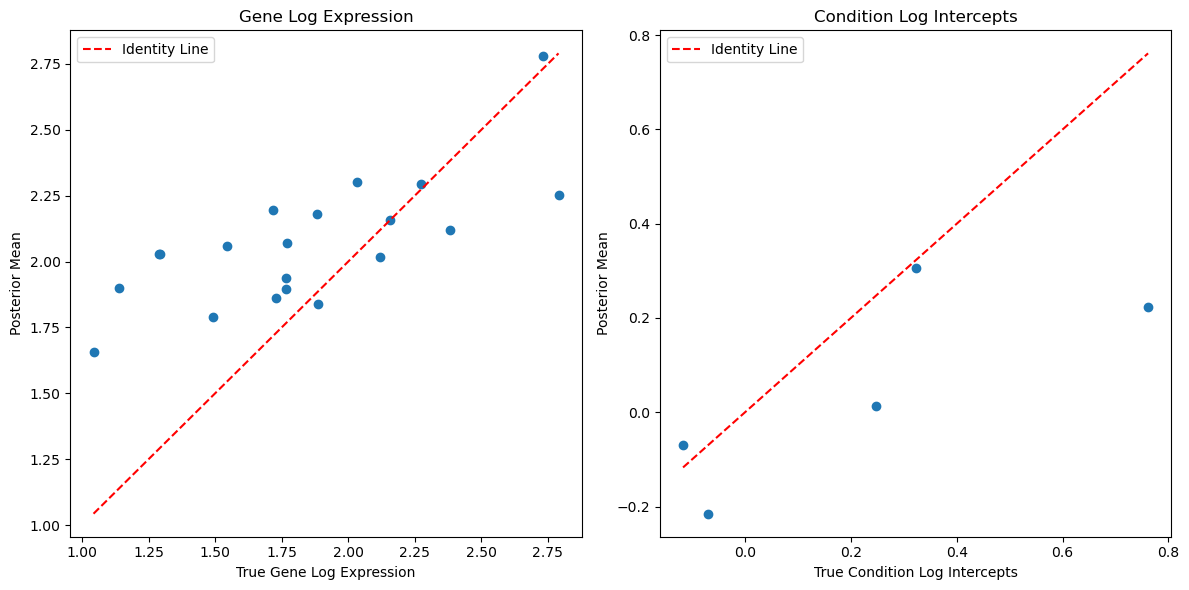

In [14]:
import matplotlib.pyplot as plt

# Calculate posterior means (if not already calculated)
post_gene_log_expr = trace.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

# Create subplots: one for genes and one for conditions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gene-level plot
axes[0].scatter(true_log_expression, post_gene_log_expr)
# Plot the identity line
min_val, max_val = min(true_log_expression), max(true_log_expression)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[0].set_xlabel("True Gene Log Expression")
axes[0].set_ylabel("Posterior Mean")
axes[0].set_title("Gene Log Expression")
axes[0].legend()

# Condition-level plot
axes[1].scatter(condition_log_intercepts, post_cond_log_int)
# Plot the identity line
min_val, max_val = min(condition_log_intercepts), max(condition_log_intercepts)
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[1].set_xlabel("True Condition Log Intercepts")
axes[1].set_ylabel("Posterior Mean")
axes[1].set_title("Condition Log Intercepts")
axes[1].legend()

plt.tight_layout()
plt.show()


array([[<Axes: title={'center': 'gene_log_expression\n0'}>,
        <Axes: title={'center': 'gene_log_expression\n1'}>,
        <Axes: title={'center': 'gene_log_expression\n2'}>,
        <Axes: title={'center': 'gene_log_expression\n3'}>],
       [<Axes: title={'center': 'gene_log_expression\n4'}>,
        <Axes: title={'center': 'gene_log_expression\n5'}>,
        <Axes: title={'center': 'gene_log_expression\n6'}>,
        <Axes: title={'center': 'gene_log_expression\n7'}>],
       [<Axes: title={'center': 'gene_log_expression\n8'}>,
        <Axes: title={'center': 'gene_log_expression\n9'}>,
        <Axes: title={'center': 'gene_log_expression\n10'}>,
        <Axes: title={'center': 'gene_log_expression\n11'}>],
       [<Axes: title={'center': 'gene_log_expression\n12'}>,
        <Axes: title={'center': 'gene_log_expression\n13'}>,
        <Axes: title={'center': 'gene_log_expression\n14'}>,
        <Axes: title={'center': 'gene_log_expression\n15'}>],
       [<Axes: title={'center'

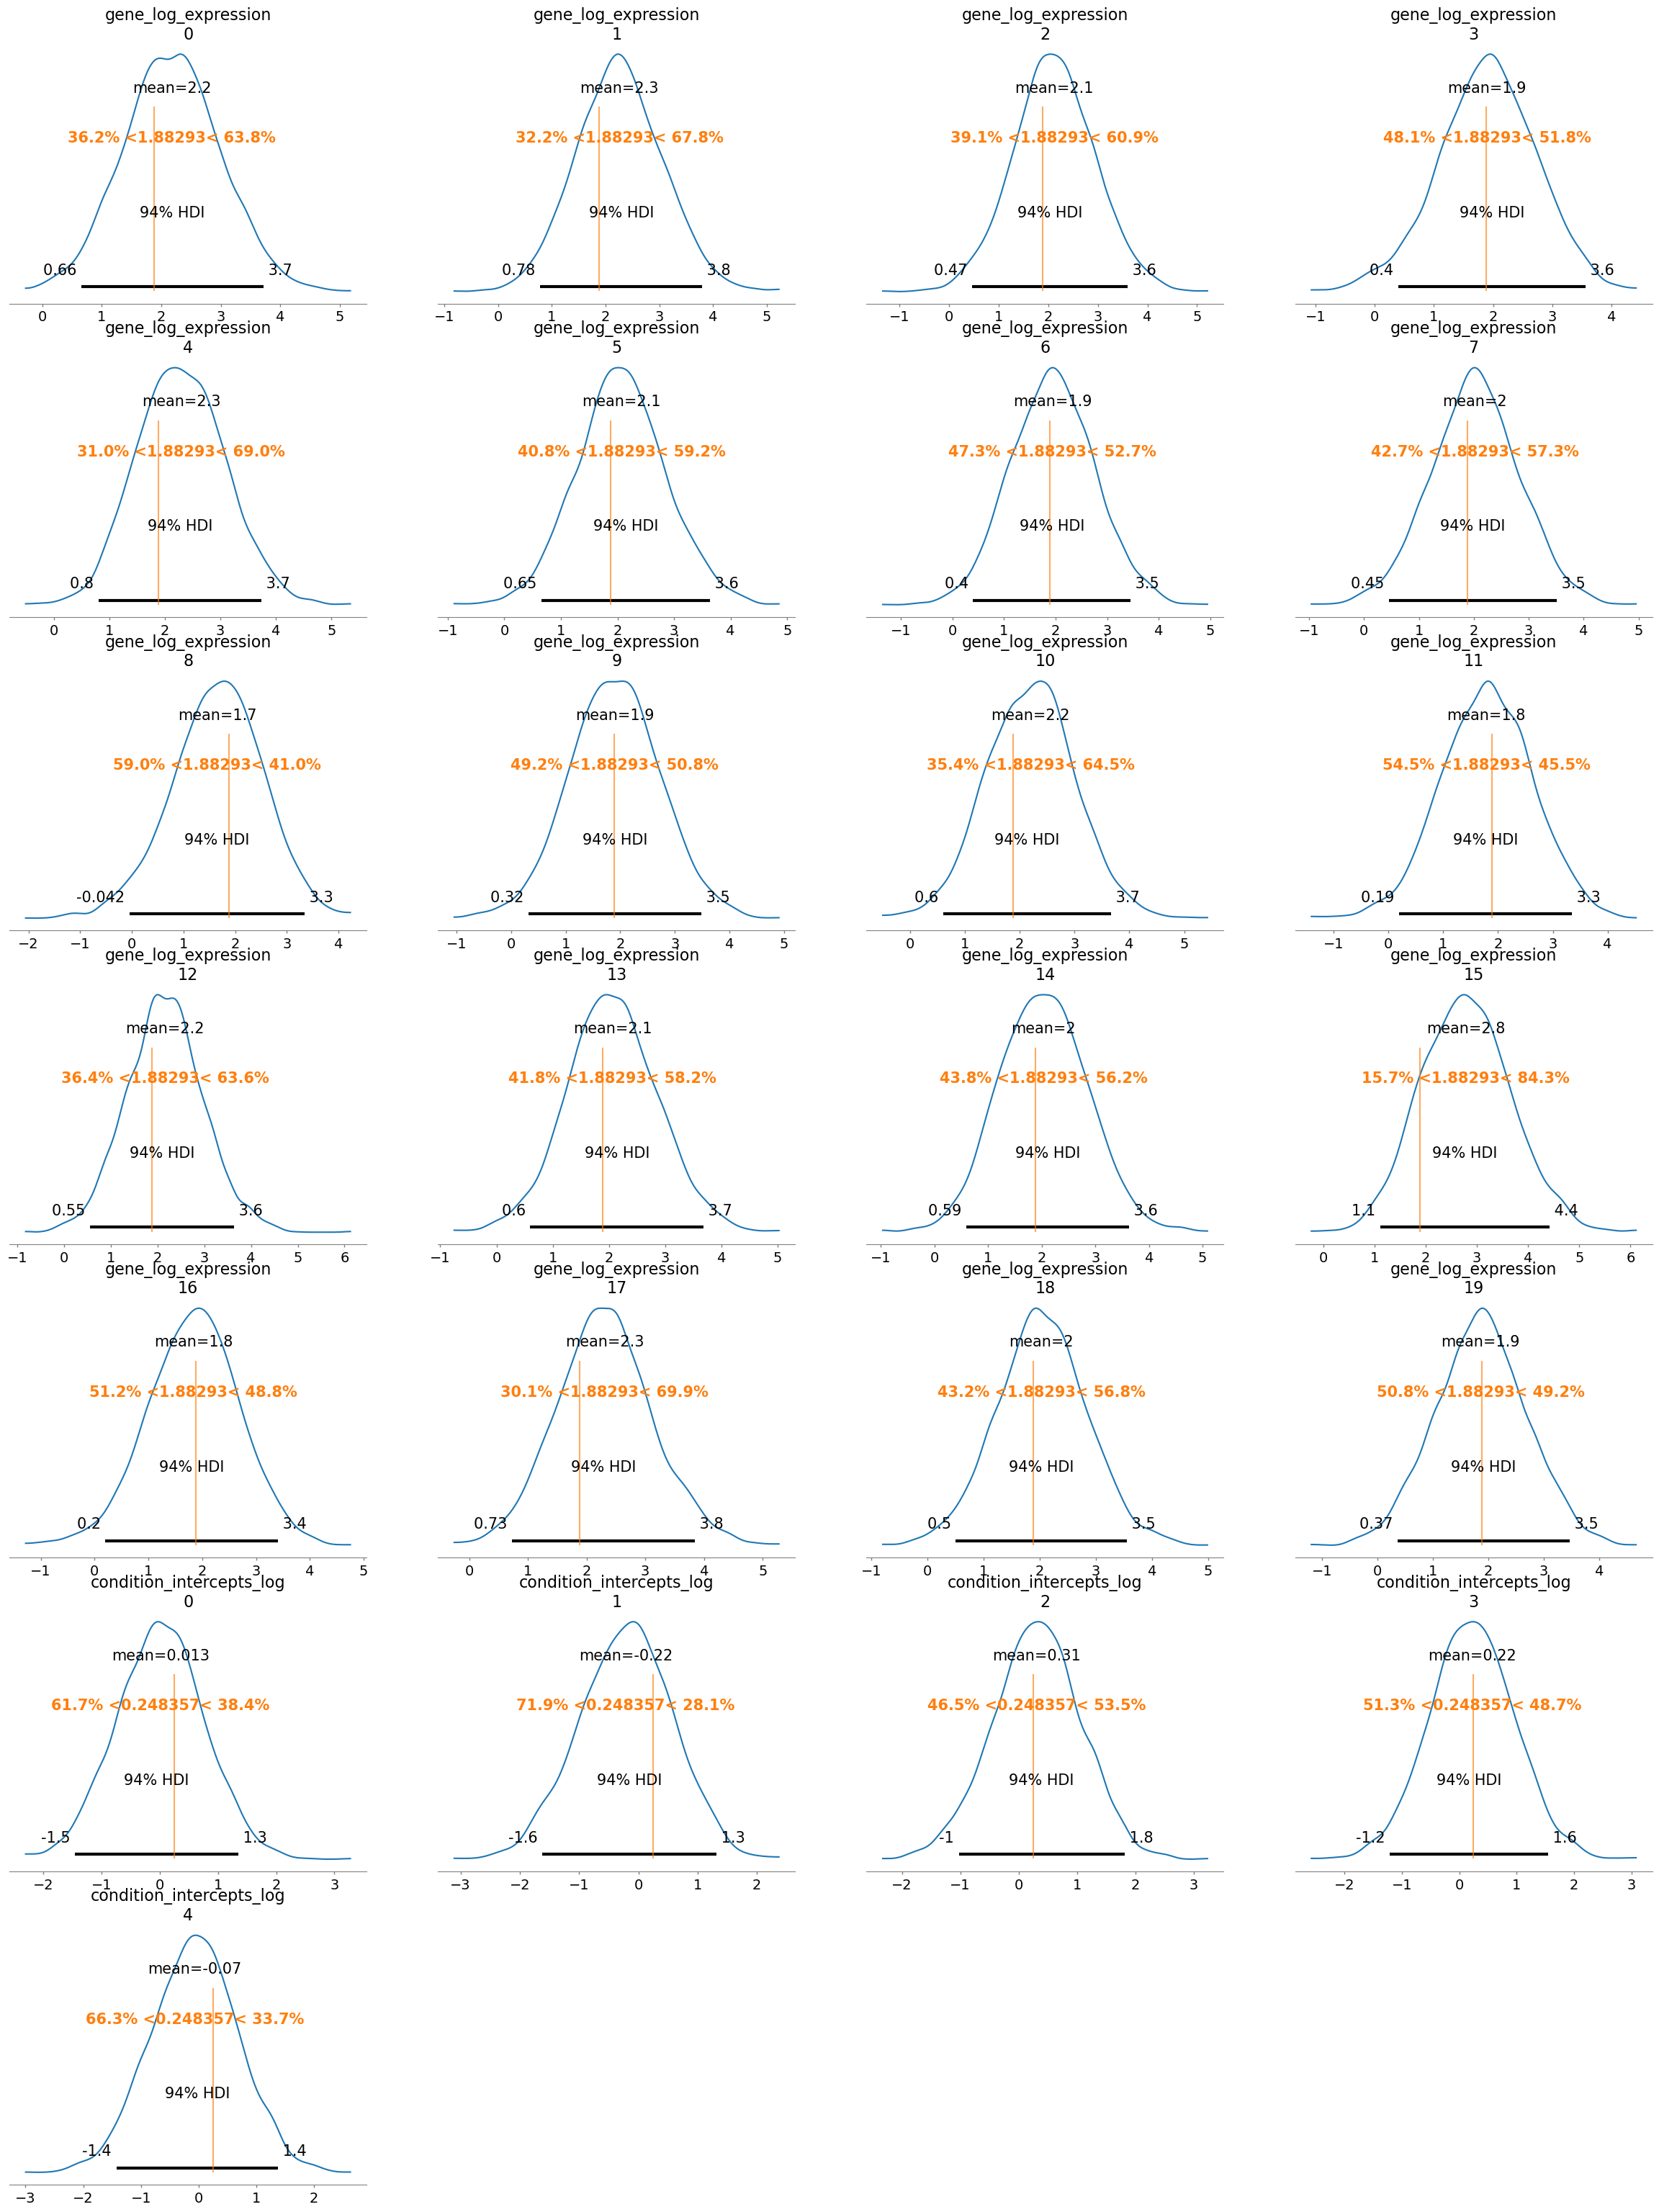

In [16]:
import arviz as az
import numpy as np

# Create a reference dictionary:
# For gene_log_expression: each subplot gets its corresponding true value.
# For condition_intercepts_log: since your simulation provided condition_intercepts on the original scale,
# we convert them to log-scale.
ref_vals = {
    "gene_log_expression": [{"ref_val": v} for v in true_log_expression.tolist()],
    "condition_intercepts_log": [{"ref_val": np.log(ci)} for ci in condition_intercepts.tolist()]
}

# Now, call az.plot_posterior with the dictionary for ref_val
az.plot_posterior(
    trace,
    var_names=["gene_log_expression", "condition_intercepts_log"],
    ref_val=ref_vals
)


# Variational Inference 

In [6]:
with pm.Model() as model:
    # Constants
    ref_seq_depth_shared = pm.Data("ref_seq_depth", ref_seq_depth)
    ref_gene_length_shared = pm.Data("ref_gene_length", ref_gene_length)
    seq_depth_shared = pm.Data("seq_depth", seq_depth)

    # Global gene-level variation
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)
    gene_log_expression = pm.Normal("gene_log_expression", mu=mu_gene, sigma=sigma_gene, shape=n_genes)

    # Condition-level variation
    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)
    condition_intercepts_log = pm.Normal("condition_intercepts_log", mu=mu_cond, sigma=sigma_cond, shape=n_conditions)

    # Dispersion
    alpha = pm.HalfCauchy('alpha', beta=2)

    # Compute mean
    log_mu = gene_log_expression[:, None] + condition_intercepts_log[None, :]
    log_mu += pm.math.log(seq_depth_shared / ref_seq_depth_shared)
    log_mu += pm.math.log(gene_lengths[:, None] / ref_gene_length_shared)
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Negative Binomial Likelihood
    pm.NegativeBinomial("observed", mu=mu, alpha=alpha, observed=observed_counts)

    # --------------------------
    # Fit VI
    # --------------------------
    pm.fit(
    n=300_000,
    method='fullrank_advi',
    callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=0.02)],  # ← slightly looser
    progressbar=True
)
    trace_vi = approx.sample(1000)

    # # --------------------------
    # # Fit MCMC
    # # --------------------------
    # trace_mcmc = pm.sample(
    #     draws=1000,
    #     tune=1000,
    #     target_accept=0.9,
    #     return_inferencedata=True,
    #     progressbar=True
    # )


/scratch/hr2547/myenv/lib64/python3.9/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/scratch/hr2547/myenv/lib64/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


Finished [100%]: Average Loss = 134.78


Finished [100%]: Average Loss = 134.78


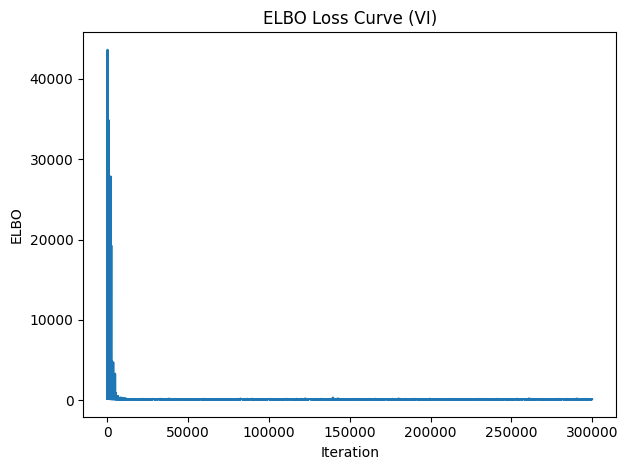

In [5]:
# --------------------------
# ELBO Plot for VI
# --------------------------
plt.plot(approx.hist)
plt.title("ELBO Loss Curve (VI)")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.tight_layout()
plt.show()

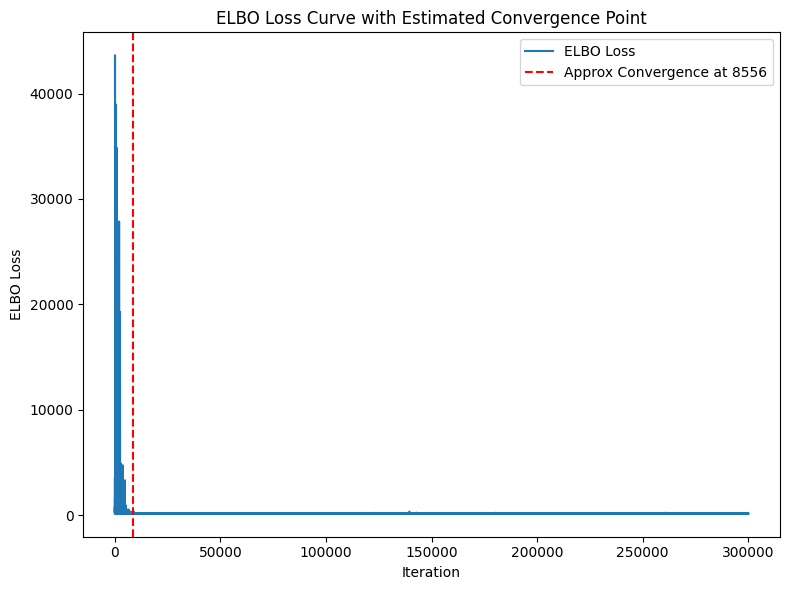

In [9]:
import matplotlib.pyplot as plt
import numpy as np

elbo_losses = approx.hist
iterations = np.arange(len(elbo_losses))

# Smooth the ELBO loss
window_size = 500  # You can adjust
smoothed = np.convolve(elbo_losses, np.ones(window_size)/window_size, mode='valid')

# Approximate convergence = when smoothed ELBO stabilizes
convergence_threshold = np.median(smoothed[-500:]) + 10  # Allow a small margin
convergence_idx = np.argmax(smoothed < convergence_threshold)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(iterations, elbo_losses, label='ELBO Loss')
if convergence_idx > 0:
    plt.axvline(x=convergence_idx, color='red', linestyle='--', label=f'Approx Convergence at {convergence_idx}')
plt.xlabel('Iteration')
plt.ylabel('ELBO Loss')
plt.title('ELBO Loss Curve with Estimated Convergence Point')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# --- Convergence Reporting ---

def report_vi_convergence(approx):
    elbo_vals = np.array(approx.hist)
    final_elbo = elbo_vals[-1]
    initial_elbo = elbo_vals[0]
    
    # Check how much ELBO improved
    elbo_improvement = initial_elbo - final_elbo
    improvement_pct = 100 * elbo_improvement / np.abs(initial_elbo)
    
    # Estimate convergence point
    diffs = np.abs(np.diff(elbo_vals))
    tolerance = 1.0  # you can adjust
    convergence_idx = np.where(diffs < tolerance)[0]
    convergence_point = convergence_idx[0] if len(convergence_idx) > 0 else None
    
    print("📋 VI Convergence Report")
    print("-" * 30)
    print(f"Initial ELBO: {initial_elbo:.2f}")
    print(f"Final ELBO: {final_elbo:.2f}")
    print(f"Total Improvement: {elbo_improvement:.2f} ({improvement_pct:.2f}%)")
    if convergence_point:
        print(f"Approximate convergence detected around {convergence_point} iterations.")
    else:
        print("Convergence not clearly detected within ELBO tolerance.")

# Call it:
report_vi_convergence(approx)


📋 VI Convergence Report
------------------------------
Initial ELBO: 327.09
Final ELBO: 133.62
Total Improvement: 193.47 (59.15%)
Approximate convergence detected around 103 iterations.


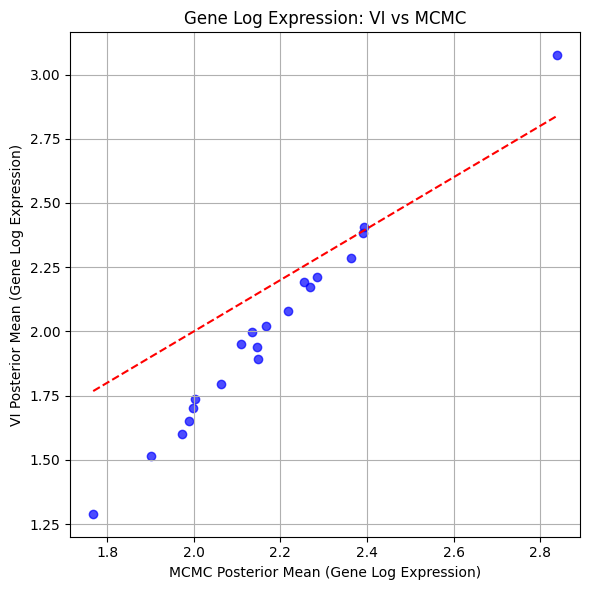

In [7]:
# --------------------------
# Scatter plots for comparison
# --------------------------
post_gene_log_expr_vi = trace_vi.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values.flatten()
post_cond_log_int_vi = trace_vi.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values.flatten()

post_gene_log_expr_mcmc = trace_mcmc.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values.flatten()
post_cond_log_int_mcmc = trace_mcmc.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values.flatten()

# Plot 1: Gene Log Expression
plt.figure(figsize=(6, 6))
plt.scatter(post_gene_log_expr_mcmc, post_gene_log_expr_vi, color='blue', alpha=0.7)
plt.plot([post_gene_log_expr_mcmc.min(), post_gene_log_expr_mcmc.max()],
         [post_gene_log_expr_mcmc.min(), post_gene_log_expr_mcmc.max()],
         color='red', linestyle='--')
plt.xlabel("MCMC Posterior Mean (Gene Log Expression)")
plt.ylabel("VI Posterior Mean (Gene Log Expression)")
plt.title("Gene Log Expression: VI vs MCMC")
plt.grid(True)
plt.tight_layout()
plt.show()


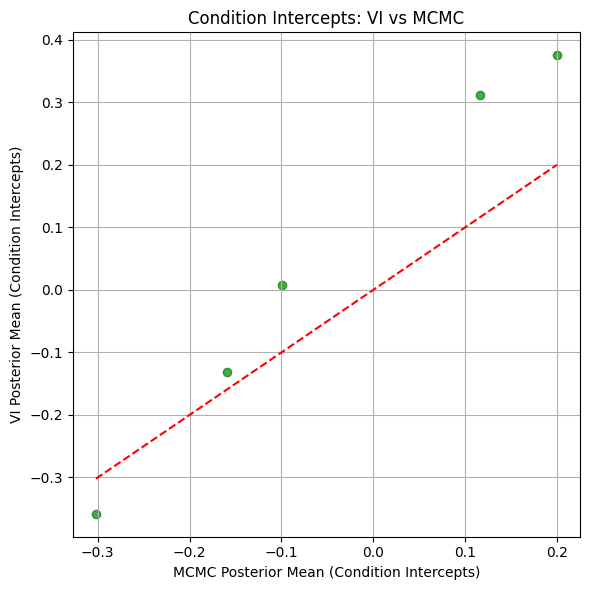

In [8]:
# Plot 2: Condition Intercepts
plt.figure(figsize=(6, 6))
plt.scatter(post_cond_log_int_mcmc, post_cond_log_int_vi, color='green', alpha=0.7)
plt.plot([post_cond_log_int_mcmc.min(), post_cond_log_int_mcmc.max()],
         [post_cond_log_int_mcmc.min(), post_cond_log_int_mcmc.max()],
         color='red', linestyle='--')
plt.xlabel("MCMC Posterior Mean (Condition Intercepts)")
plt.ylabel("VI Posterior Mean (Condition Intercepts)")
plt.title("Condition Intercepts: VI vs MCMC")
plt.grid(True)
plt.tight_layout()
plt.show()

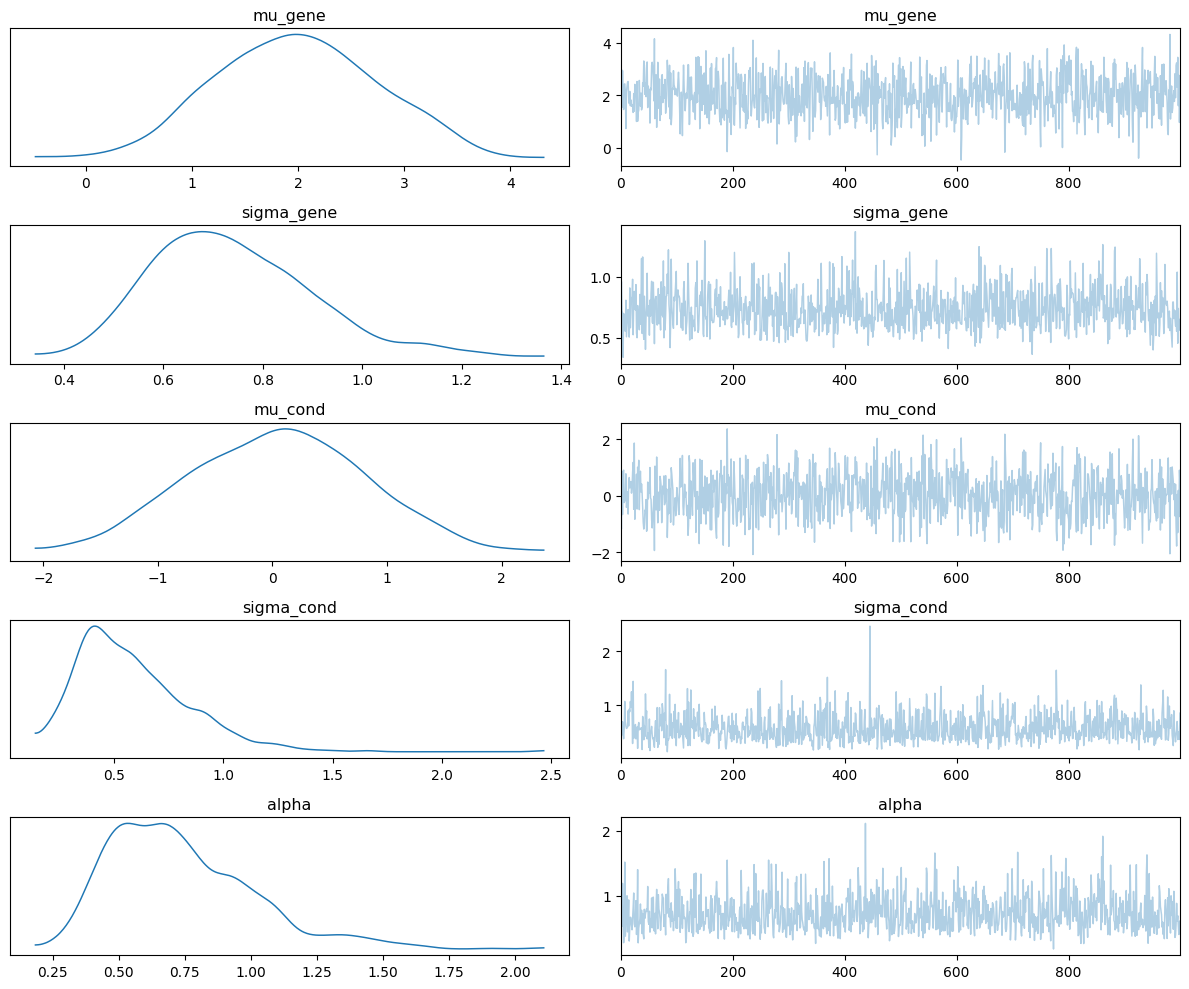

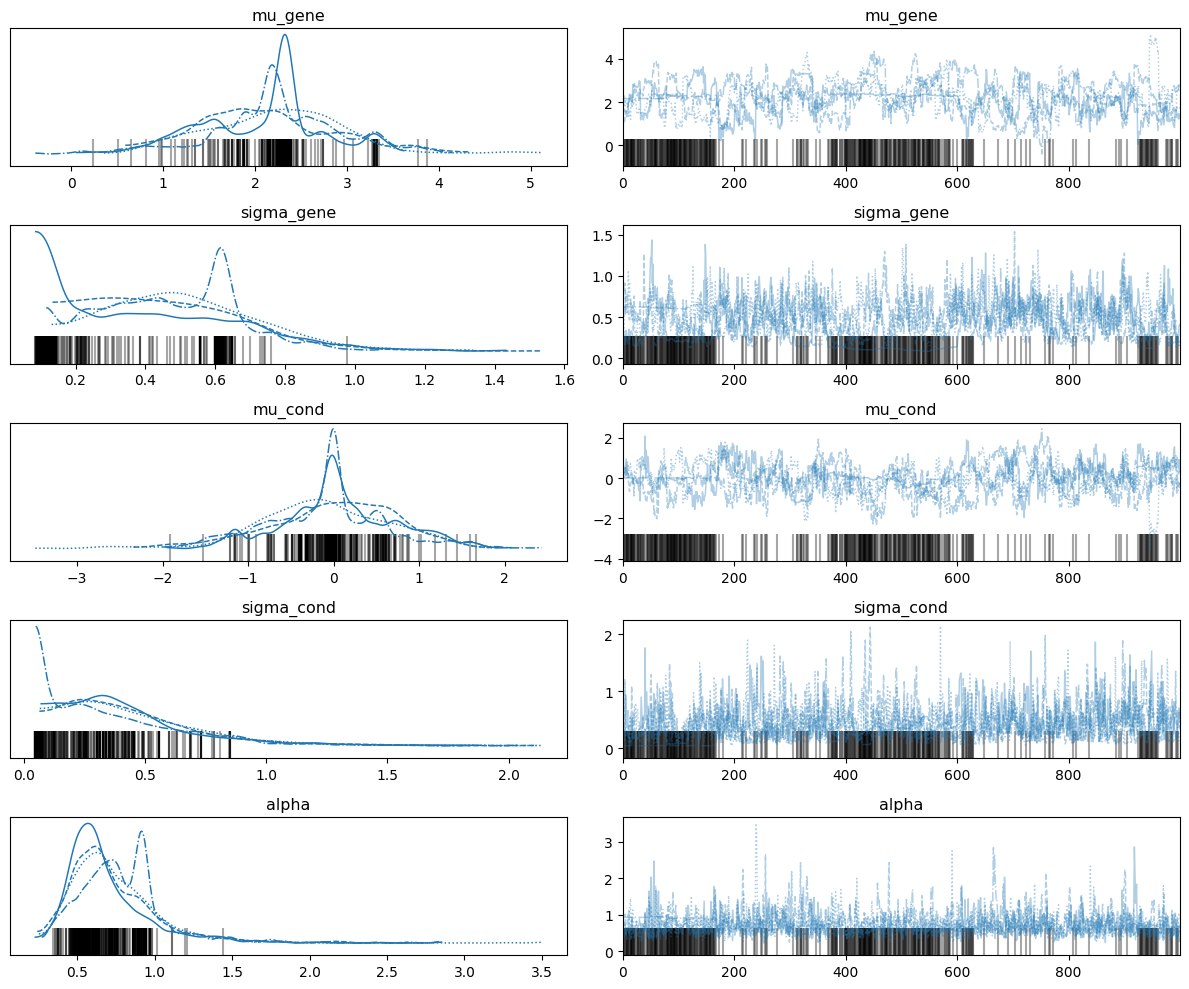

In [9]:

az.plot_trace(trace_vi, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

az.plot_trace(trace_mcmc, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

In [11]:
print("VI Convergence trace")
az.summary(trace_vi)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


VI Convergence trace


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_gene                 1.991  0.776   0.710    3.488      0.024    0.017   
gene_log_expression[0]  2.192  0.923   0.498    3.888      0.029    0.020   
gene_log_expression[1]  2.285  0.949   0.414    3.983      0.030    0.021   
gene_log_expression[2]  2.081  0.962   0.265    3.875      0.030    0.021   
gene_log_expression[3]  1.702  0.943  -0.006    3.451      0.032    0.023   
...                       ...    ...     ...      ...        ...      ...   
mu[19, 0]               0.478  0.435   0.034    1.093      0.014    0.010   
mu[19, 1]               0.333  0.283   0.026    0.878      0.009    0.006   
mu[19, 2]               0.689  0.619   0.048    1.729      0.021    0.015   
mu[19, 3]               0.639  0.554   0.054    1.525      0.018    0.013   
mu[19, 4]               0.424  0.396   0.024    1.014      0.013    0.009   

                        ess_bulk  ess_tail  r_hat  
mu_gene                   1017.0     983.0    NaN  
gene_log_expression[0]    1036.0    1072.0    NaN  
gene_log_expression[1]    1018.0     889.0    NaN  
gene_log_expression[2]    1018.0     810.0    NaN  
gene_log_expression[3]     873.0     966.0    NaN  
...                          ...       ...    ...  
mu[19, 0]                  921.0     904.0    NaN  
mu[19, 1]                  901.0     947.0    NaN  
mu[19, 2]                  962.0     846.0    NaN  
mu[19, 3]                  931.0     668.0    NaN  
mu[19, 4]                  900.0     918.0    NaN  

[130 rows x 9 columns]

In [12]:
print("MCMC trace")
az.summary(trace_mcmc)

MCMC trace


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_gene                 2.172  0.729   0.788    3.496      0.060    0.042   
gene_log_expression[0]  2.256  0.817   0.756    3.830      0.062    0.044   
gene_log_expression[1]  2.362  0.825   0.769    3.894      0.063    0.045   
gene_log_expression[2]  2.218  0.825   0.683    3.855      0.061    0.043   
gene_log_expression[3]  1.997  0.834   0.398    3.516      0.062    0.044   
...                       ...    ...     ...      ...        ...      ...   
mu[19, 0]               0.526  0.303   0.084    1.036      0.008    0.005   
mu[19, 1]               0.441  0.264   0.058    0.883      0.011    0.008   
mu[19, 2]               0.704  0.423   0.106    1.340      0.009    0.007   
mu[19, 3]               0.649  0.375   0.110    1.243      0.009    0.006   
mu[19, 4]               0.496  0.279   0.075    0.950      0.008    0.006   

                        ess_bulk  ess_tail  r_hat  
mu_gene                    146.0     238.0   1.03  
gene_log_expression[0]     173.0     282.0   1.01  
gene_log_expression[1]     166.0     340.0   1.03  
gene_log_expression[2]     183.0     430.0   1.01  
gene_log_expression[3]     177.0     415.0   1.01  
...                          ...       ...    ...  
mu[19, 0]                 1120.0    1954.0   1.01  
mu[19, 1]                  392.0    1277.0   1.01  
mu[19, 2]                 1379.0    2050.0   1.01  
mu[19, 3]                 1102.0    1991.0   1.01  
mu[19, 4]                  884.0    1906.0   1.01  

[130 rows x 9 columns]

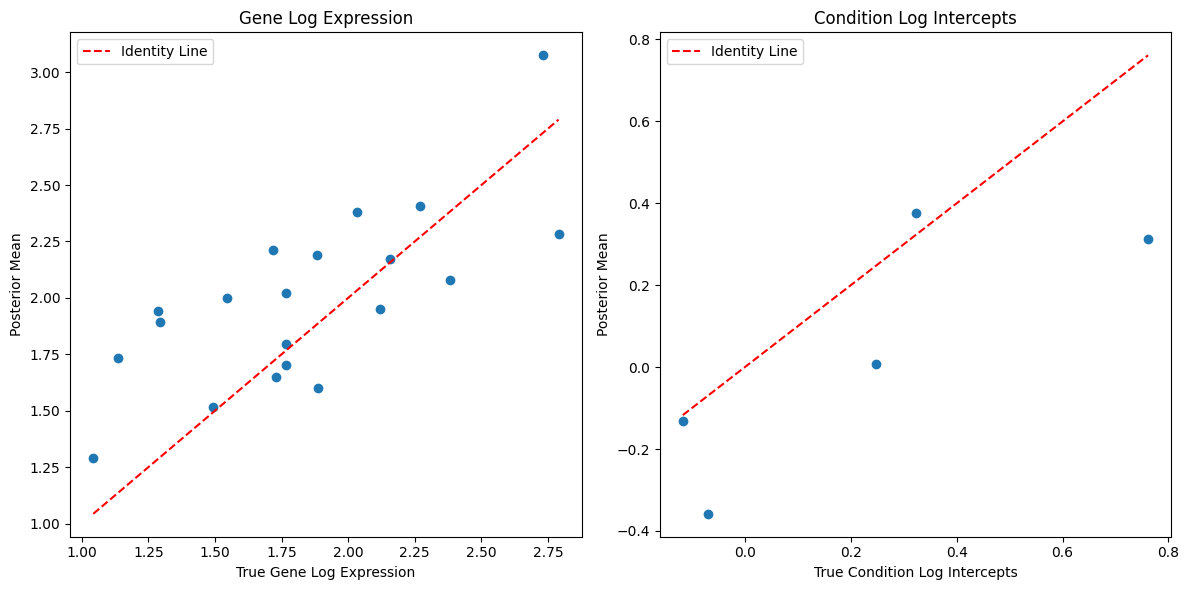

In [13]:
import matplotlib.pyplot as plt

# Calculate posterior means (if not already calculated)
post_gene_log_expr = trace_vi.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace_vi.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

# Create subplots: one for genes and one for conditions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gene-level plot
axes[0].scatter(true_log_expression, post_gene_log_expr)
# Plot the identity line
min_val, max_val = min(true_log_expression), max(true_log_expression)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[0].set_xlabel("True Gene Log Expression")
axes[0].set_ylabel("Posterior Mean")
axes[0].set_title("Gene Log Expression")
axes[0].legend()

# Condition-level plot
axes[1].scatter(condition_log_intercepts, post_cond_log_int)
# Plot the identity line
min_val, max_val = min(condition_log_intercepts), max(condition_log_intercepts)
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[1].set_xlabel("True Condition Log Intercepts")
axes[1].set_ylabel("Posterior Mean")
axes[1].set_title("Condition Log Intercepts")
axes[1].legend()

plt.tight_layout()
plt.show()


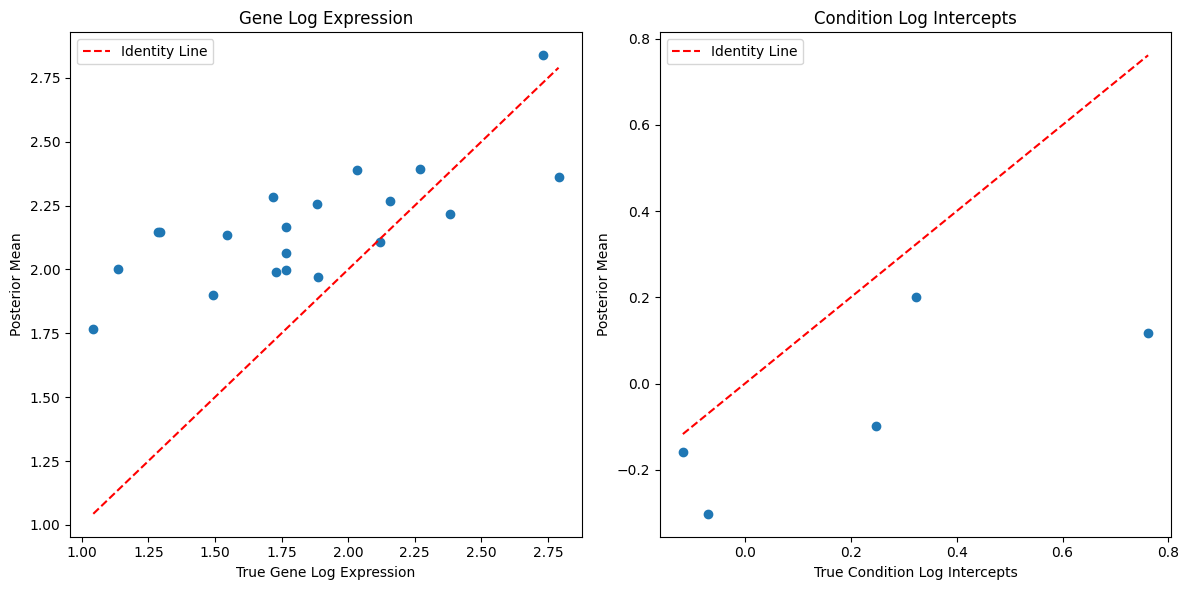

In [14]:
import matplotlib.pyplot as plt

# Calculate posterior means (if not already calculated)
post_gene_log_expr = trace_mcmc.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace_mcmc.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

# Create subplots: one for genes and one for conditions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gene-level plot
axes[0].scatter(true_log_expression, post_gene_log_expr)
# Plot the identity line
min_val, max_val = min(true_log_expression), max(true_log_expression)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[0].set_xlabel("True Gene Log Expression")
axes[0].set_ylabel("Posterior Mean")
axes[0].set_title("Gene Log Expression")
axes[0].legend()

# Condition-level plot
axes[1].scatter(condition_log_intercepts, post_cond_log_int)
# Plot the identity line
min_val, max_val = min(condition_log_intercepts), max(condition_log_intercepts)
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label="Identity Line")
axes[1].set_xlabel("True Condition Log Intercepts")
axes[1].set_ylabel("Posterior Mean")
axes[1].set_title("Condition Log Intercepts")
axes[1].legend()

plt.tight_layout()
plt.show()


array([[<Axes: title={'center': 'gene_log_expression\n0'}>,
        <Axes: title={'center': 'gene_log_expression\n1'}>,
        <Axes: title={'center': 'gene_log_expression\n2'}>,
        <Axes: title={'center': 'gene_log_expression\n3'}>],
       [<Axes: title={'center': 'gene_log_expression\n4'}>,
        <Axes: title={'center': 'gene_log_expression\n5'}>,
        <Axes: title={'center': 'gene_log_expression\n6'}>,
        <Axes: title={'center': 'gene_log_expression\n7'}>],
       [<Axes: title={'center': 'gene_log_expression\n8'}>,
        <Axes: title={'center': 'gene_log_expression\n9'}>,
        <Axes: title={'center': 'gene_log_expression\n10'}>,
        <Axes: title={'center': 'gene_log_expression\n11'}>],
       [<Axes: title={'center': 'gene_log_expression\n12'}>,
        <Axes: title={'center': 'gene_log_expression\n13'}>,
        <Axes: title={'center': 'gene_log_expression\n14'}>,
        <Axes: title={'center': 'gene_log_expression\n15'}>],
       [<Axes: title={'center'

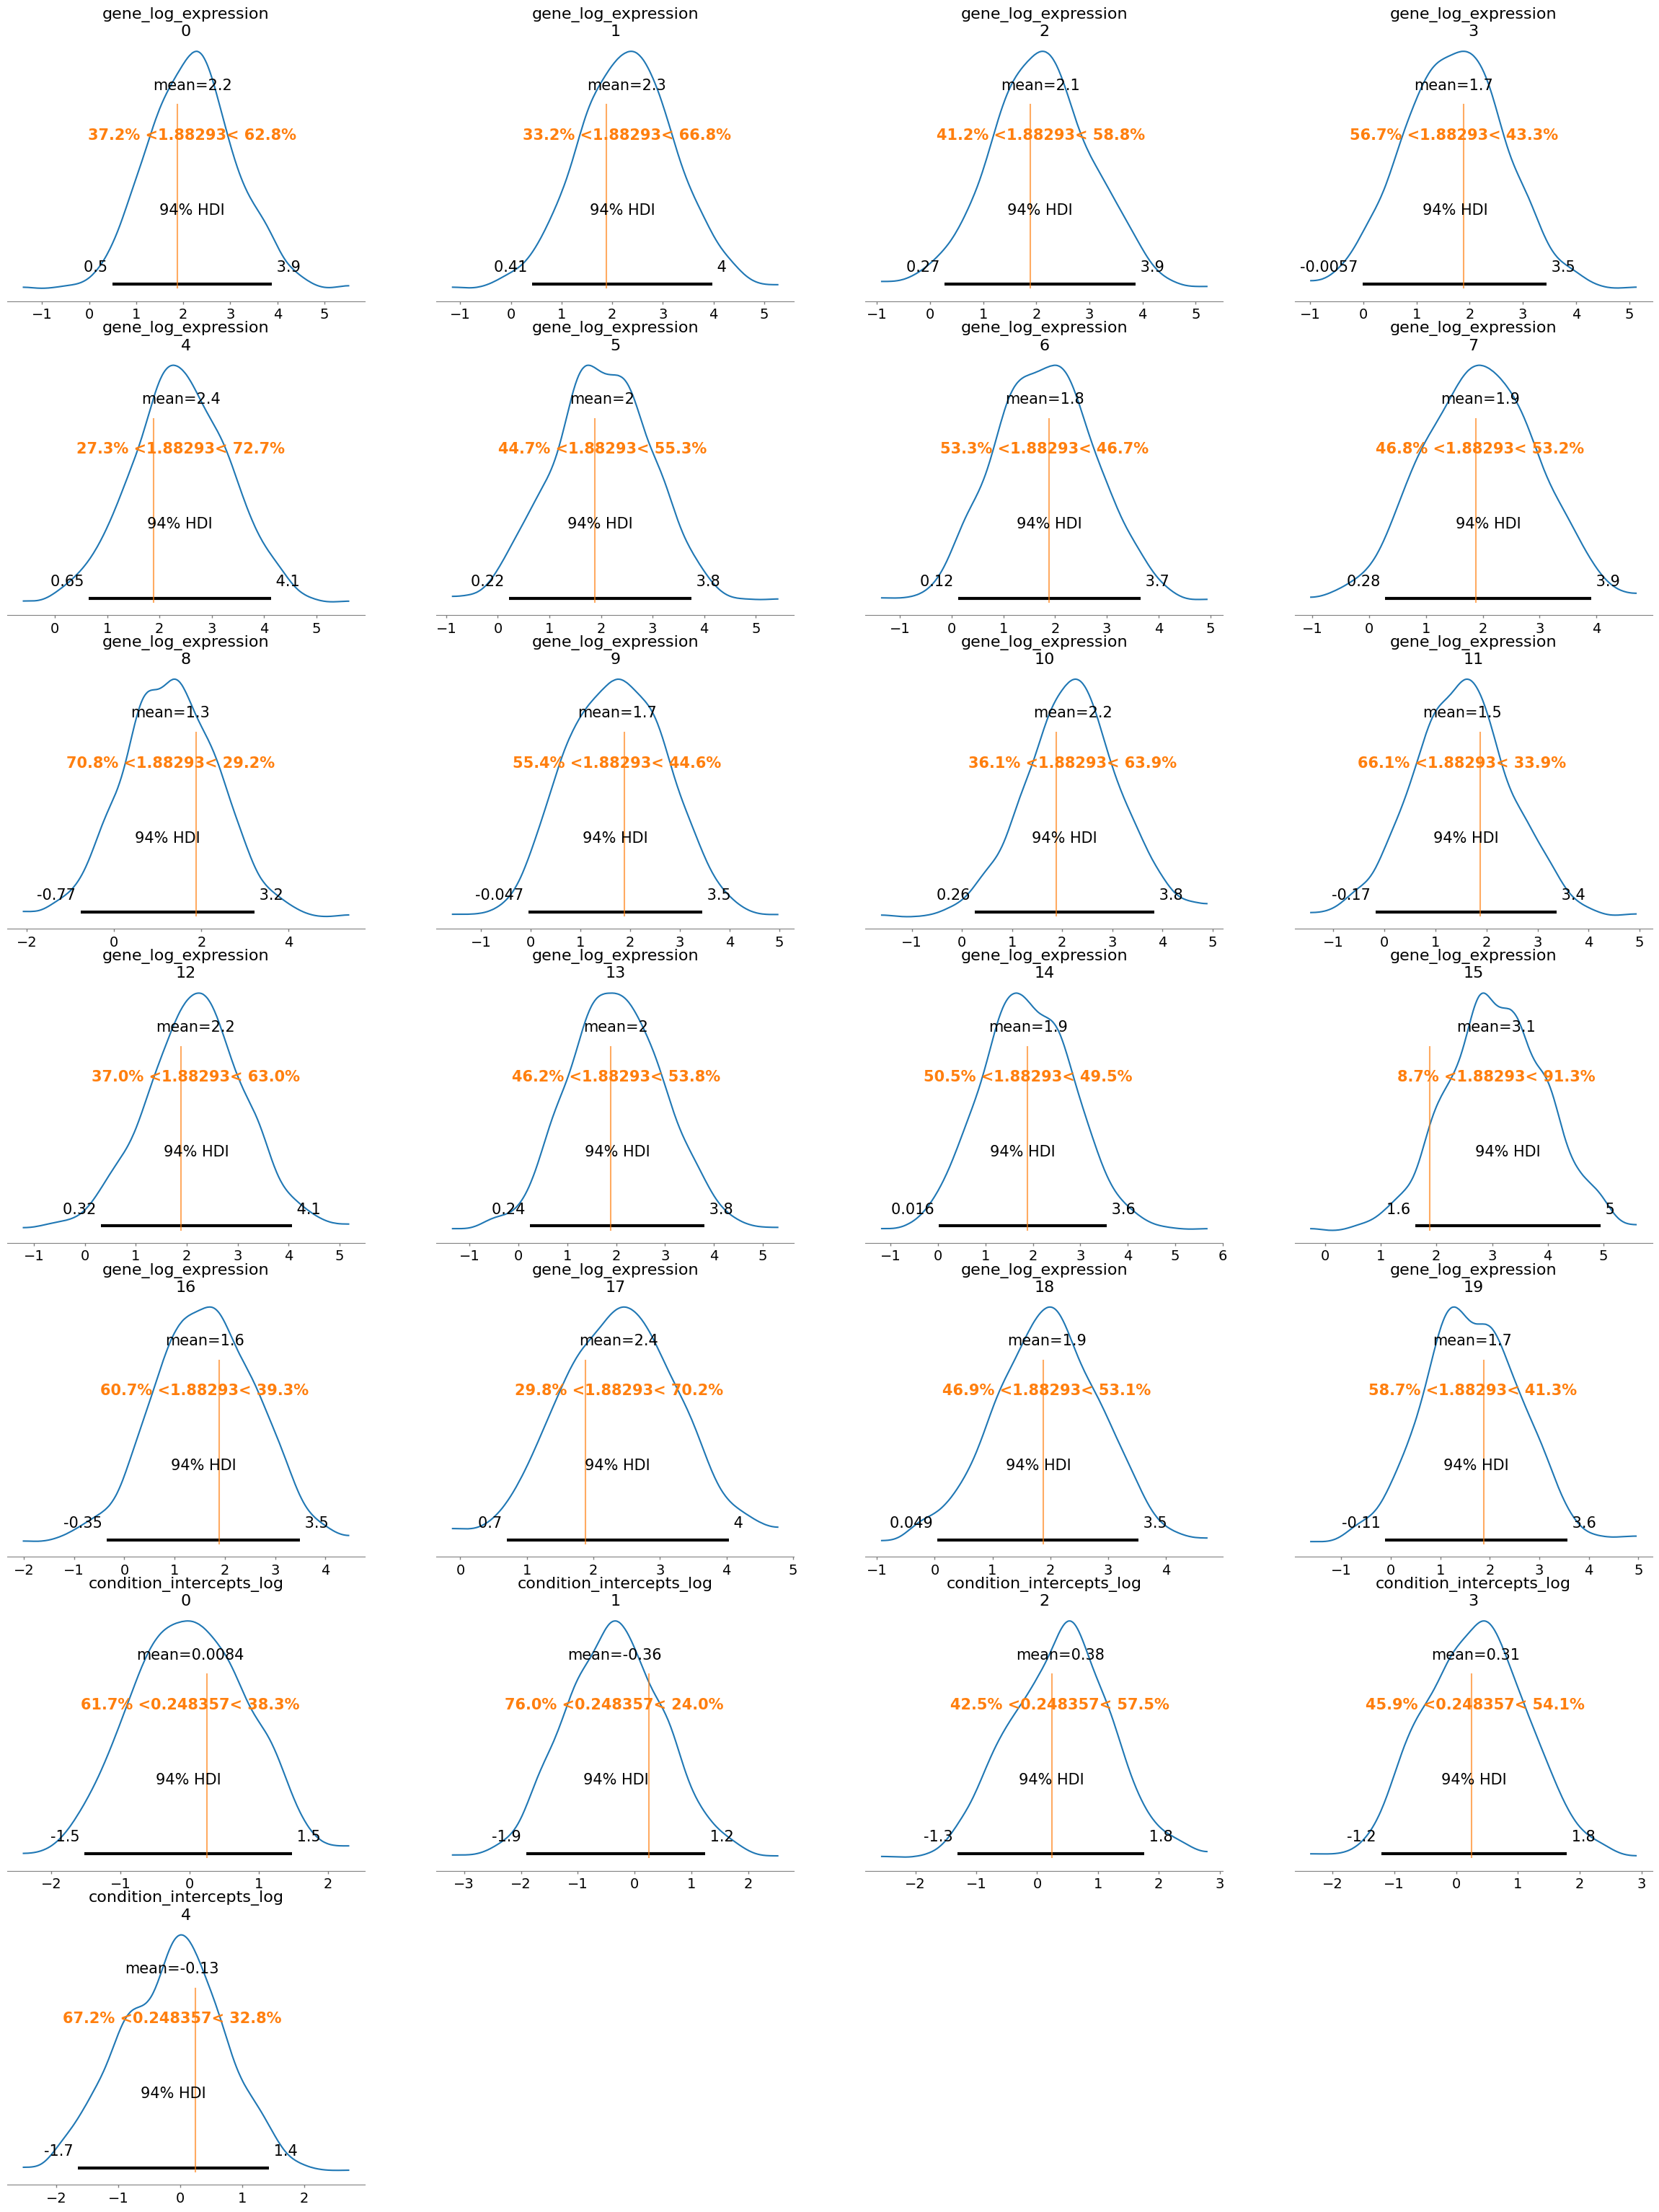

In [15]:
import arviz as az
import numpy as np

# Create a reference dictionary:
# For gene_log_expression: each subplot gets its corresponding true value.
# For condition_intercepts_log: since your simulation provided condition_intercepts on the original scale,
# we convert them to log-scale.
ref_vals = {
    "gene_log_expression": [{"ref_val": v} for v in true_log_expression.tolist()],
    "condition_intercepts_log": [{"ref_val": np.log(ci)} for ci in condition_intercepts.tolist()]
}

# Now, call az.plot_posterior with the dictionary for ref_val
az.plot_posterior(
    trace_vi,
    var_names=["gene_log_expression", "condition_intercepts_log"],
    ref_val=ref_vals
)


array([[<Axes: title={'center': 'gene_log_expression\n0'}>,
        <Axes: title={'center': 'gene_log_expression\n1'}>,
        <Axes: title={'center': 'gene_log_expression\n2'}>,
        <Axes: title={'center': 'gene_log_expression\n3'}>],
       [<Axes: title={'center': 'gene_log_expression\n4'}>,
        <Axes: title={'center': 'gene_log_expression\n5'}>,
        <Axes: title={'center': 'gene_log_expression\n6'}>,
        <Axes: title={'center': 'gene_log_expression\n7'}>],
       [<Axes: title={'center': 'gene_log_expression\n8'}>,
        <Axes: title={'center': 'gene_log_expression\n9'}>,
        <Axes: title={'center': 'gene_log_expression\n10'}>,
        <Axes: title={'center': 'gene_log_expression\n11'}>],
       [<Axes: title={'center': 'gene_log_expression\n12'}>,
        <Axes: title={'center': 'gene_log_expression\n13'}>,
        <Axes: title={'center': 'gene_log_expression\n14'}>,
        <Axes: title={'center': 'gene_log_expression\n15'}>],
       [<Axes: title={'center'

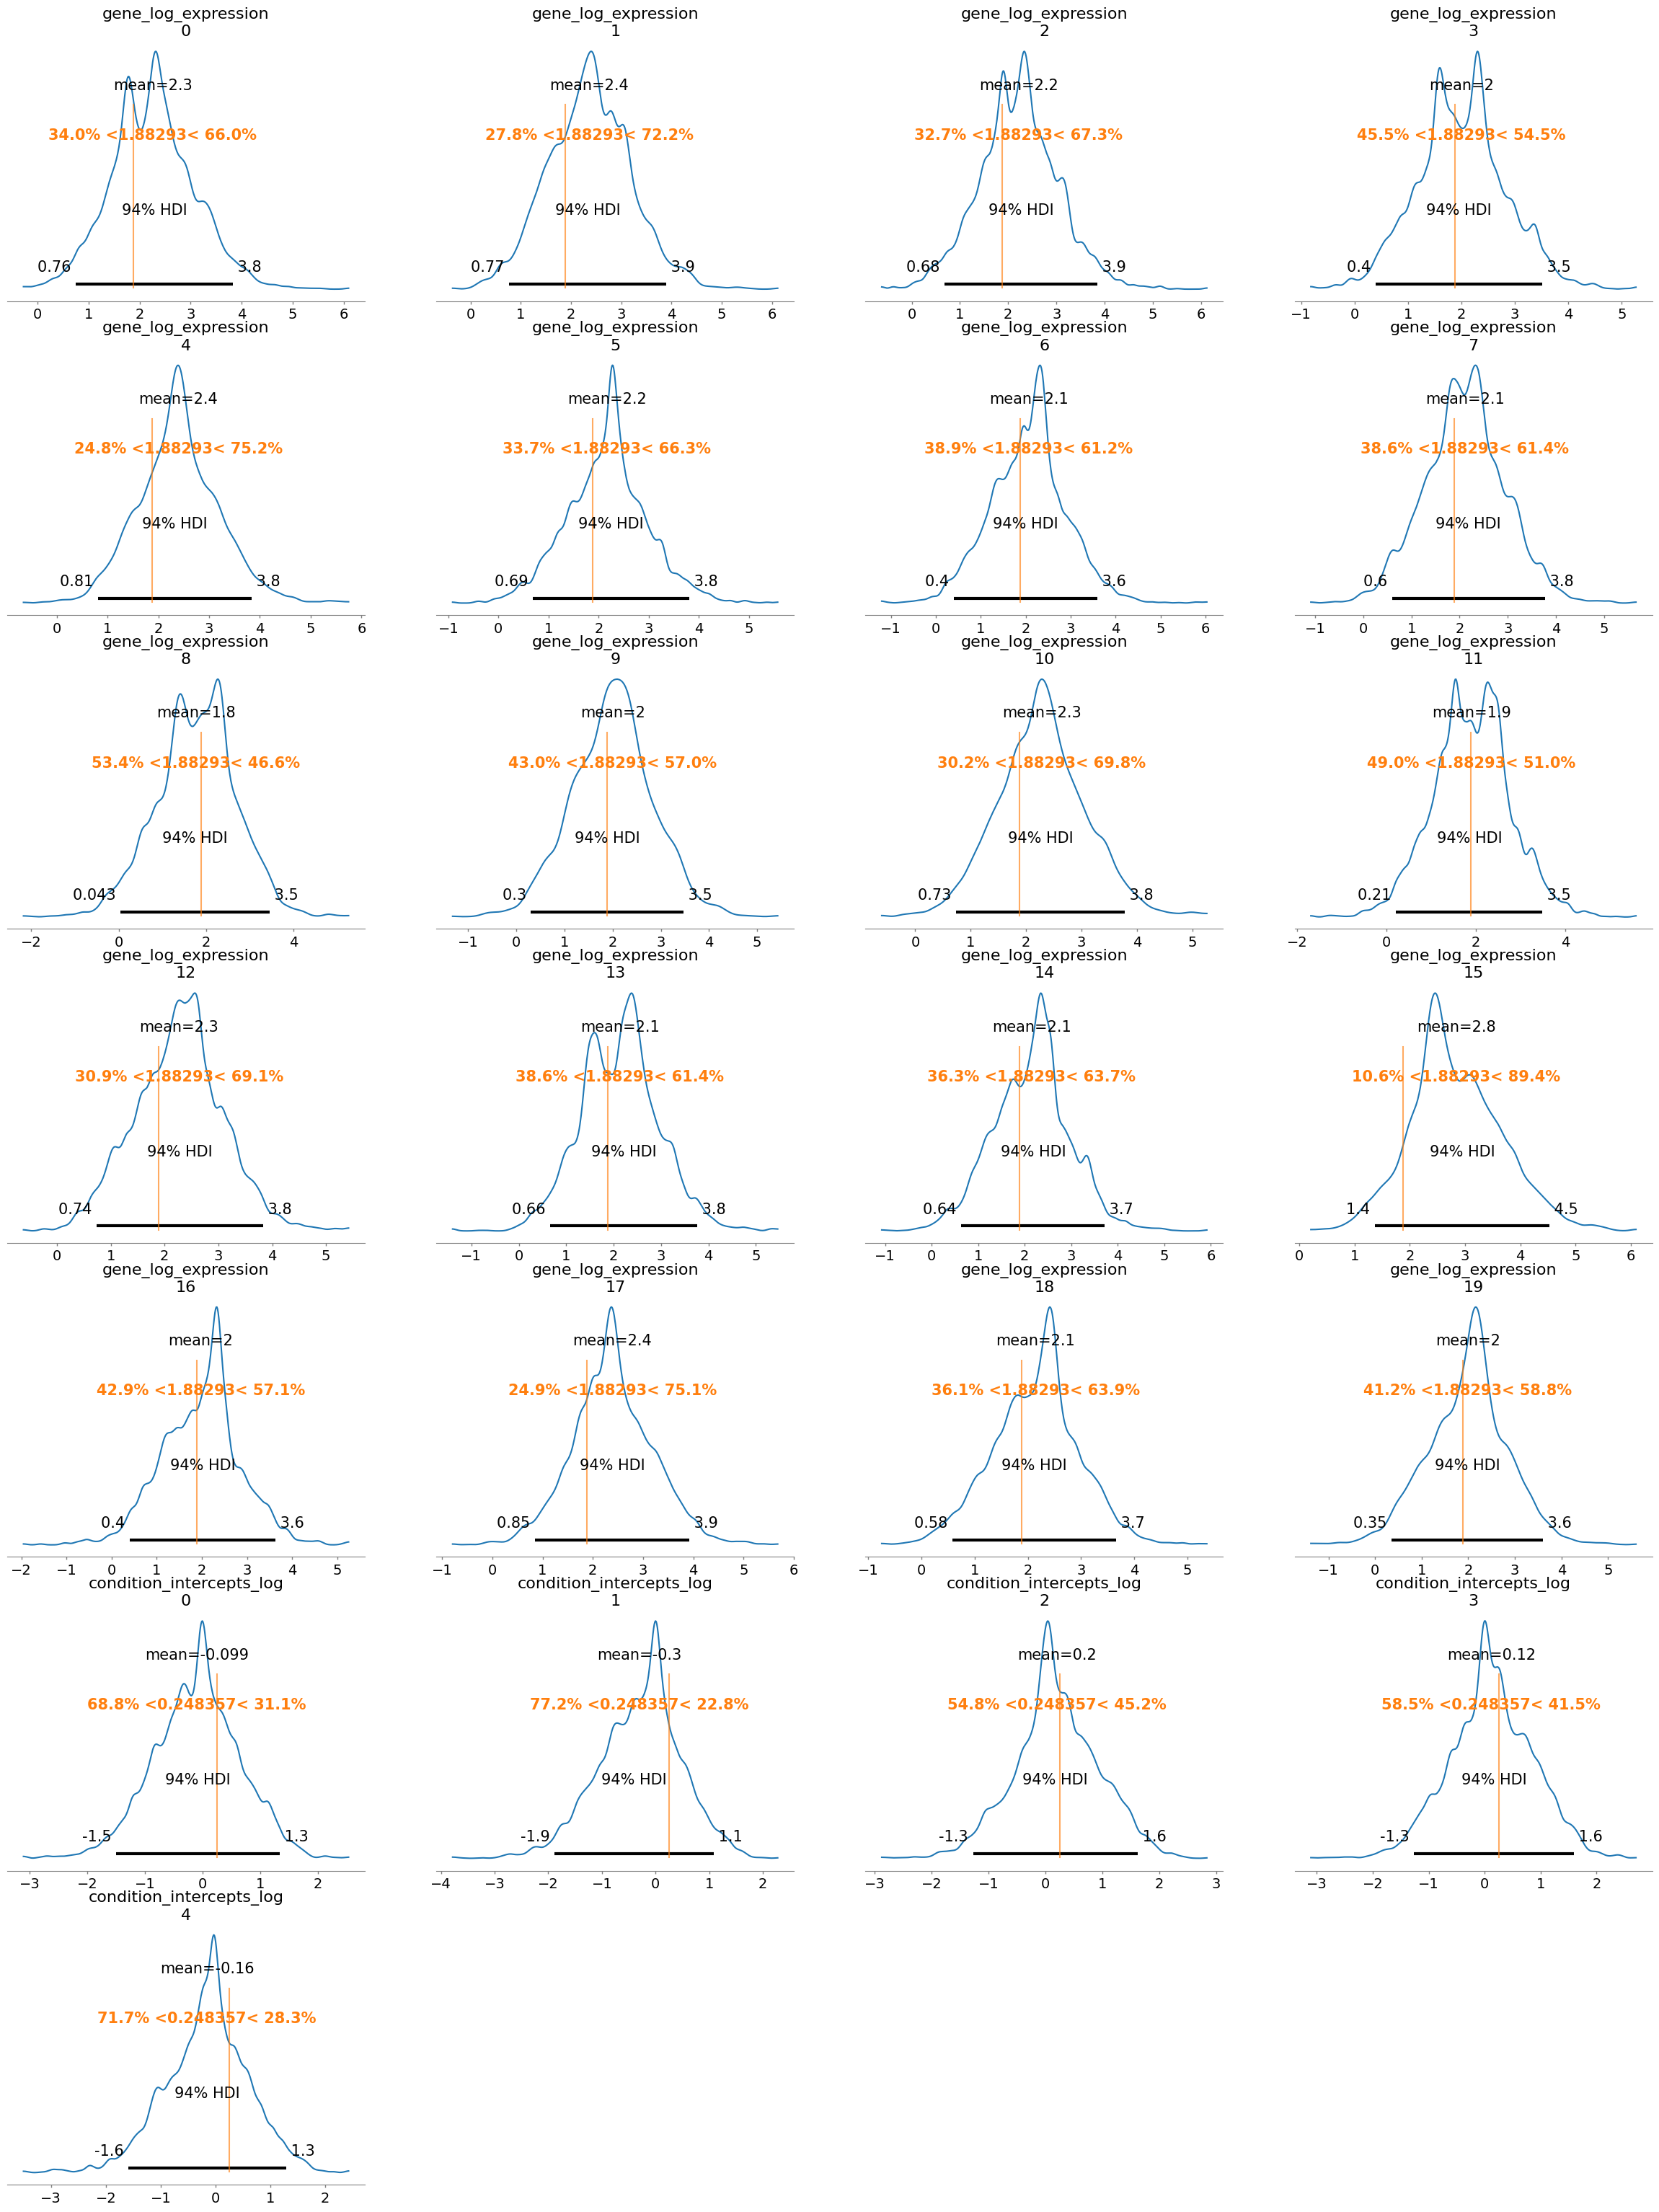

In [16]:
import arviz as az
import numpy as np

# Create a reference dictionary:
# For gene_log_expression: each subplot gets its corresponding true value.
# For condition_intercepts_log: since your simulation provided condition_intercepts on the original scale,
# we convert them to log-scale.
ref_vals = {
    "gene_log_expression": [{"ref_val": v} for v in true_log_expression.tolist()],
    "condition_intercepts_log": [{"ref_val": np.log(ci)} for ci in condition_intercepts.tolist()]
}

# Now, call az.plot_posterior with the dictionary for ref_val
az.plot_posterior(
    trace_mcmc,
    var_names=["gene_log_expression", "condition_intercepts_log"],
    ref_val=ref_vals
)
